In [1]:
import numpy as np
import matplotlib as mpl
import os
import matplotlib.pyplot as plt
import matplotlib.animation
import tensorflow as tf
from numpy import genfromtxt
import pandas as pd
import sys
sys.path.append(os.getcwd())
import tsa_utils

#Model parameters
BATCH_SIZE = 5
FILTER_COUNT= 8
KERNEL_SIZE1=[3,3,16]
XSTRIDE=1
YSTRIDE=1
POOLSIZE=5
STEPS=100000
XSIZE=270
YSIZE=440
LEARNING_RATE=0.1
MODEL_ID="tsa26"
WEIGHTS=[1, 5]
#DATA_PATH=os.environ["DATA_PATH"]
DATA_PATH="./images/"
tf.logging.set_verbosity(tf.logging.INFO)


In [2]:
def build_model(data, labels, mode):
    print("DATA " + str(data))
    data = tf.reshape(data, [BATCH_SIZE, 16, YSIZE, XSIZE, 1])
    conv1 = tf.layers.conv3d(inputs=data, filters=2, kernel_size=(3,10,10), padding="same", strides=(2,XSTRIDE,YSTRIDE), name="conv1")
    pool1 = tf.layers.max_pooling3d(inputs=conv1, pool_size=[3, 3, 3], strides=(3,3,3), name="pool1")
    print ("pool1 " + str(pool1))
    print ("CONV " + str(conv1))
    tf.Print(conv1, [conv1], message="CONV1 ")
    conv2 = tf.layers.conv3d(inputs=pool1, filters=2, kernel_size=(2,3,3), padding="same", strides=(1, 2, 2), name="conv2")
    print ("CONV2 " + str(conv2))
    pool2 = tf.layers.max_pooling3d(inputs=conv2, pool_size=[2, 5, 5], strides=(2,5,5), name="pool1")
    pool1=tf.identity(pool1, name="pool1")
    print("POOL2 " + str(pool2))
    flat_pool = tf.reshape(pool2, [BATCH_SIZE, 252])
    flat_pool=tf.identity(flat_pool, name="flat_pool")
    sum_pool = tf.reduce_sum(pool1, axis=[1,2,3,4]) 
    sum_pool=tf.identity(sum_pool, name="sum_pool")
    sum_data = tf.reduce_sum(data, axis=[1,2,3])
    sum_data=tf.identity(sum_data, name="sum_data")
    print ("FLAT POOL " + str(flat_pool))
    logits = tf.layers.dense(inputs=flat_pool, units=2)
    logits =tf.identity(logits, name="logits")
    logits = tf.reshape(logits, [BATCH_SIZE,2])
    print("LOGITS " + str(logits))
    #labels = tf.one_hot(labels, depth=2)
    print ("LABELS " + str(labels))
    flat_labels = tf.reshape(labels, [BATCH_SIZE, 2])
    #info = tf.concat([sum_data, tf.to_float(flat_labels)[:,0]], 1)
    #info = tf.stack([sum_data, tf.to_float(flat_labels)[:,0]], axis=1)
    #info = tf.identity(info, name="info")
    test_labels=tf.identity(flat_labels, name="labels")
    print("LABELS " + str(test_labels))
    class_weights=tf.reduce_sum(tf.multiply(flat_labels, tf.constant(WEIGHTS, dtype=tf.int64)), axis=1)
    print("CLASS WEIGHTS " + str(class_weights))
    loss = tf.losses.softmax_cross_entropy(onehot_labels=test_labels, logits=logits, weights=class_weights)
    #loss = tf.losses.mean_squared_error(test_labels, logits)
    predictions = {
        "classes": tf.argmax(
          input=logits, axis=1, name="classes"),
      "probabilities": tf.nn.softmax(
          logits, name="softmax_tensor")}
    print("PREDICTIONS " + str(predictions))
    train_op = tf.contrib.layers.optimize_loss(
        loss=loss,
        global_step=tf.contrib.framework.get_global_step(),
        learning_rate=LEARNING_RATE,
        optimizer="SGD")
    print ("TRAIN OP " + str(train_op))
    print ("MODE " + str(mode))
    print ("LOSS " + str(loss))
    return tf.contrib.learn.ModelFnOps(mode=mode, predictions=predictions, loss=loss, train_op=train_op)


In [3]:

image_df = pd.read_csv(DATA_PATH + '/stage1_labels.csv')
image_df['zone'] = image_df['Id'].str.split("_", expand=True)[1].str.strip()
image_df['id'] = image_df['Id'].str.split("_", expand=True)[0].str.strip()

tf.reset_default_graph()
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
sess.run(tf.initialize_all_variables())

tsa_classifier = tf.contrib.learn.Estimator(model_fn=build_model, model_dir="/tmp/" + MODEL_ID)



Instructions for updating:
Use `tf.global_variables_initializer` instead.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': None, '_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_tf_random_seed': None, '_task_type': None, '_environment': 'local', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x8d85350>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_num_worker_replicas': 0, '_task_id': 0, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_evaluation_master': '', '_keep_checkpoint_every_n_hours': 10000, '_master': ''}


In [17]:
i = tsa_utils.InputImagesIterator(ids, DATA_PATH, 100000, "bottom", "right")

In [16]:

#tensors_to_log =  {"info":"info","probabilities": "softmax_tensor", "actual":"labels", "logits":"logits", "sum_flat_pool":"sum_flat_pool"}
tensors_to_log =  {"sum_pool":"sum_pool","flat_pool":"flat_pool","probabilities": "softmax_tensor", "actual":"labels", "logits":"logits", "sum_pool":"sum_pool"}
logging_hook = tf.train.LoggingTensorHook(tensors=tensors_to_log, every_n_iter=5)

ids = image_df["id"].unique()[:29]
ids =  ['00360f79fd6e02781457eda48f85da90', '0043db5e8c819bffc15261b1f1ac5e42',
 '0050492f92e22eed3474ae3a6fc907fa', '006ec59fa59dd80a64c85347eef810c7',
 '0097503ee9fa0606559c56458b281a08', '011516ab0eca7cad7f5257672ddde70e',
 '01941f33fd090ae5df8c95992c027862', '01c08047f617de893bef104fb309203a',
 '0240c8f1e89e855dcd8f1fa6b1e2b944', '0322661ef29f9c81af295cf40f758469',
 '037024e4a7122e10546ebc41859c6833', '038d648c2f29cb0f945c865be25e32e9',
 '0397026df63bbc8fd88f9860c6e35b4a', '03a36512c2c6d71c33b3429b8b59494e',
 '04b32b70b4ab15cad85d43e3b5359239', '052117021fc1396db6bae78ffe923ee4',
 '0535d52b89f5dcca44563b62592ca366', '05709d5e54f8fdc77fe233cf7df78b81',
 '05aea64cd02c88b94d0663be46f4d2bf', '06323e0c225d04e325d70d6adc0240ef',
 '06726105fabadca043737601d06415a8', '068be31bfd5fcc08699a50f08f255d9b',
 '06f07ef12a24cd5ab6aa457ac8afa2a0', '06ff02c1f431d0c21b945b4ea459cc88',
 '0748878870d90c426ee75d30aed5b024', '077c5701d8ee08e469ada0ef3b105cba',
 '07a2f948ec404e8b729541d3c2702a69', '07d04f2ba71419b0d7228f2c50c14318',
 '087d7648e320f02c2c41e029f6cc2cd0']
ids.sort()
print ("IDS " + str(ids))



IDS ['00360f79fd6e02781457eda48f85da90', '0043db5e8c819bffc15261b1f1ac5e42', '0050492f92e22eed3474ae3a6fc907fa', '006ec59fa59dd80a64c85347eef810c7', '0097503ee9fa0606559c56458b281a08', '011516ab0eca7cad7f5257672ddde70e', '01941f33fd090ae5df8c95992c027862', '01c08047f617de893bef104fb309203a', '0240c8f1e89e855dcd8f1fa6b1e2b944', '0322661ef29f9c81af295cf40f758469', '037024e4a7122e10546ebc41859c6833', '038d648c2f29cb0f945c865be25e32e9', '0397026df63bbc8fd88f9860c6e35b4a', '03a36512c2c6d71c33b3429b8b59494e', '04b32b70b4ab15cad85d43e3b5359239', '052117021fc1396db6bae78ffe923ee4', '0535d52b89f5dcca44563b62592ca366', '05709d5e54f8fdc77fe233cf7df78b81', '05aea64cd02c88b94d0663be46f4d2bf', '06323e0c225d04e325d70d6adc0240ef', '06726105fabadca043737601d06415a8', '068be31bfd5fcc08699a50f08f255d9b', '06f07ef12a24cd5ab6aa457ac8afa2a0', '06ff02c1f431d0c21b945b4ea459cc88', '0748878870d90c426ee75d30aed5b024', '077c5701d8ee08e469ada0ef3b105cba', '07a2f948ec404e8b729541d3c2702a69', '07d04f2ba71419b0d7228f

In [20]:
for j in range(0,30):
    data = i.next()
    print(data[0])

[[ 0.52524638  0.51744569  0.58765186 ...,  2.04898097  1.86696489
   1.994376  ]
 [ 0.509645    0.52004589  0.6318558  ...,  1.67194758  1.46912971
   1.8565639 ]
 [ 0.54084776  0.48624293  0.52784658 ...,  1.76035537  1.57053873
   1.53933597]
 ..., 
 [ 0.71506311  0.61885462  0.78526937 ...,  1.81756041  2.17379184
   2.08278379]
 [ 0.65785807  0.62145486  0.74626587 ...,  1.95537268  2.23879761
   2.37140939]
 [ 0.67085921  0.74106542  0.61885462 ...,  2.69123757  2.40781264
   1.91116869]]
[[  5.81722043e-06   5.40311294e-06   6.15244971e-06 ...,   1.76685735e-05
    1.79052058e-05   1.60515847e-05]
 [  5.14676094e-06   6.11301130e-06   5.77778155e-06 ...,   2.25589829e-05
    1.82798758e-05   2.09025548e-05]
 [  4.89040895e-06   4.73265391e-06   4.69321503e-06 ...,   1.87531405e-05
    1.83587526e-05   2.40576574e-05]
 ..., 
 [  7.03982232e-06   6.25104667e-06   8.16382726e-06 ...,   5.55298029e-05
    5.71862329e-05   3.90049536e-05]
 [  6.80318954e-06   6.46796025e-06   6.64543

[[ 0.51828074  0.50910762  0.48464599 ...,  3.30843504  3.79919657
   3.72581162]
 [ 0.53204039  0.46018436  0.58707906 ...,  3.21517509  3.38487771
   3.19835781]
 [ 0.51675188  0.53356925  0.53509812 ...,  2.90940479  3.28397364
   3.35888726]
 ..., 
 [ 0.76442584  0.8332242   0.89132054 ...,  3.42004132  3.26715599
   3.11732874]
 [ 0.72467569  0.71397376  0.62224267 ...,  3.24422326  3.06840557
   3.05617468]
 [ 0.86991658  0.80417603  1.00445559 ...,  2.86201048  3.00113588
   3.19682877]]
[[ 0.54189559  0.51998072  0.52396522 ...,  2.05800789  2.36880096
   2.64373339]
 [ 0.47814319  0.58373312  0.51998072 ...,  2.42059978  2.79912983
   3.0242556 ]
 [ 0.46021282  0.48212769  0.52396522 ...,  3.26531954  3.55220545
   3.18562888]
 ..., 
 [ 0.84272733  0.75706002  0.66342368 ...,  2.76127685  2.19746635
   1.9225341 ]
 [ 0.63951652  0.69729213  0.64748556 ...,  2.71943936  2.51423626
   2.24528067]
 [ 0.68533855  0.67537726  0.70725346 ...,  2.03808522  2.02413939
   2.15961336]]


In [ ]:

#tsa_classifier.fit(x=tsa_utils.InputImagesIterator(ids, DATA_PATH, 10), y=tsa_utils.InputLabelsIterator(image_df, "Zone11",ids), steps=STEPS, batch_size=BATCH_SIZE, monitors=[logging_hook])

tsa_classifier.fit(x=tsa_utils.InputImagesIterator(ids, DATA_PATH, 1, "bottom", "right"), y=tsa_utils.InputLabelsIterator(image_df, "Zone11",ids), steps=STEPS, batch_size=BATCH_SIZE, monitors=[logging_hook])

filters = tsa_classifier.get_variable_value("conv2d/kernel")

print(filters.shape)

x = filters[:,:,0,0]
#plt.imshow(x)
#plt.show()


# In[21]:

dir(tf.python_io)


Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
DATA Tensor("input:0", shape=(?, 16, 440, 270), dtype=float32)
pool1 Tensor("pool1/MaxPo

In [ ]:
plt.imshow(data[10])
plt.show()

In [7]:
tsa_classifier.get_variable_names()

['OptimizeLoss/learning_rate',
 'conv1/bias',
 'conv1/kernel',
 'conv2/bias',
 'conv2/kernel',
 'dense/bias',
 'dense/kernel',
 'global_step']

In [16]:

filters = tsa_classifier.get_variable_value("conv2/kernel")

print(filters.shape)

x = filters[:,:,0,0,:]
#plt.imshow(x)
#plt.show()


# In[21]:

dir(tf.python_io)


(2, 3, 3, 2, 2)


['TFRecordCompressionType',
 'TFRecordOptions',
 'TFRecordWriter',
 '__builtins__',
 '__doc__',
 '__file__',
 '__name__',
 '__package__',
 '_allowed_symbols',
 'tf_record_iterator']

In [27]:
x = filters[1, :, :, 0, 0]

In [28]:
x.shape

(3, 3)

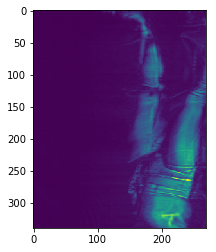

In [12]:
plt.imshow(img[2])
plt.show()

In [7]:
img = i.next()


In [8]:
img.shape

(16, 340, 270)